# 01 - Main notebook

Main notebook used to replicate the results of the project. The preprocessed data can be downloaded at this [link](https://dtudk-my.sharepoint.com/:u:/g/personal/nicit_dtu_dk/EX96_QZYCQZMhQgLV_bEnl0BgosY2sJLT1s48-sCzHR6Cw?e=jhTNmx) and saved into a data folder.

Import required packages and source files:

In [1]:
cd notebooks/

/home/nicit/deep_learning_course_wfco/notebooks


In [2]:
import numpy as np
import os
import torch
from tqdm import trange
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import init
import sys
sys.path.append('../src/')
import utils

### Data

Load preprocessed data:

In [3]:
data_filepath = '../data/5wt_dataset_1000_slsqp_simple_complete.pt'     # edit with your filepath
data = torch.load(data_filepath)
print("Data loaded")
X = data[0]
Y = data[1]
print("Loaded X shape: %s", X.shape)
print("Loaded Y shape: %s", Y.shape)

Data loaded
Loaded X shape: %s torch.Size([133920000, 18])
Loaded Y shape: %s torch.Size([133920000])


The initial amount of data made the training very slow, so I decided to consider ony 10% of the layouts in the dataset, as it seems to not compromise the performance of the model:

In [4]:
cases_per_layout = 31 * 9 * 5
n_layouts_to_keep = 9600

# Reduce dataset as training was taking too long
rows_to_keep = n_layouts_to_keep * cases_per_layout
X = X[:rows_to_keep, :]
Y = Y[:rows_to_keep]
print("Reduced X shape:", X.shape)
print("Reduced Y shape:", Y.shape)

Reduced X shape: torch.Size([13392000, 18])
Reduced Y shape: torch.Size([13392000])


Split the and normalize the dataset:

In [5]:
# Split the dataset into 60%, 20% and 20%
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = utils.split_dataset(X, Y, cases_per_layout, train_ratio=0.6, val_ratio=0.2, shuffle=False)

# Normalize the dataset
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = utils.normalize_train_based(
    X_train, Y_train, X_val, Y_val, X_test, Y_test, skip_indices=[10, 11, 12, 13, 14]
)

INFO: Total layouts: 9600


Pad and mask in case there are less than 5 wind turbines downstream:

In [6]:
PAD_VALUE = 999
# Replace the NaNs that emerged whenever there were no wake turbines, with the PAD_VALUE
X_train[torch.isnan(X_train)] = PAD_VALUE
X_val[torch.isnan(X_val)] = PAD_VALUE
X_test[torch.isnan(X_test)] = PAD_VALUE

# Create masks (1 for valid, 0 for padded)
mask_train = (X_train != PAD_VALUE).float()
mask_val = (X_val != PAD_VALUE).float()
mask_test = (X_test != PAD_VALUE).float()


### Model architecture

Below we define the architecture of the Feed Forward Neural Network (FFNN). During the project many different architecture and hyperparameters were tested, concluding with a grid search on the learning rate and network depth to refine the results.

In [7]:
class YawRegressionNet(nn.Module):
    def __init__(self, n_inputs=18, hidden_layers=[512, 256, 128], n_outputs=1, negative_slope=0.01):
        super(YawRegressionNet, self).__init__()
        layers = []
        in_features = n_inputs

        for h in hidden_layers:
            linear = nn.Linear(in_features, h)
            # init.xavier_normal_(linear.weight)
            init.kaiming_normal_(linear.weight, a=negative_slope, nonlinearity='leaky_relu')   # initialize weights with Kaiming normal
            init.constant_(linear.bias, 0.0)                                                   # initialize biases to zero
            layers.append(linear)
            # layers.append(nn.BatchNorm1d(h))                                                 # disabled since perhaps doesn't behave well with the masking
            layers.append(nn.LeakyReLU(negative_slope=negative_slope))                         # LeakyReLU activation
            layers.append(nn.Dropout(0.2))                                                     # Dropout with p=0.2
            in_features = h

        out_layer = nn.Linear(in_features, n_outputs)
        init.kaiming_normal_(out_layer.weight, a=negative_slope, nonlinearity='leaky_relu')    # initialize weights with Kaiming normal
        # init.xavier_normal_(out_layer.weight)              
        init.constant_(out_layer.bias, 0.0)                                                    # initialize biases to zero
        layers.append(out_layer)
        self.model = nn.Sequential(*layers)

    def forward(self, x, mask=None):
        if mask is not None:
            x = x * mask                                                                       # zero out padded features, so that they do not affect the weights
        return self.model(x)


### Training

We now train the FFNN. As the training with a maximum epoch of 100 took more than 2 hours on 1 GPU, in this notebook we load the trained model (or we train on fewer epochs.)

In [8]:
learning_rate = 5e-4                # LR
hidden_layers = [1000, 1000]        # Hidden layers
batch_size = 512                    # Batch size
torch.manual_seed(42)               # Random seed

# Prepare datasets with masks and loaders
train_dataset = TensorDataset(X_train, Y_train, mask_train)
val_dataset = TensorDataset(X_val, Y_val, mask_val)
test_dataset = TensorDataset(X_test, Y_test, mask_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: %s", device)  # device can be a torch.device; it will be str()-formatted

Device: %s cpu


In [9]:
# Load model
model = YawRegressionNet(n_inputs=X_train.shape[1], hidden_layers=hidden_layers, n_outputs=1).to(device)
# Set MSE as loss criterion
criterion = torch.nn.MSELoss()
# Adam optimizer for gradients                                 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Lists to store RMSE
train_rmse_deg, val_rmse_deg = [], []


# Early stopping parameters
patience = 10  # number of epochs to wait for improvement
best_val_rmse = float('inf')
epochs_no_improve = 0
best_model_state = None

In [10]:
use_preloaded_model = True          # Set to True to use a preloaded model (best model of the grid search), if not will train from scratch
n_epochs = 3                        # N° of epochs

if use_preloaded_model:

    model_folder = "../models"
    model_filename = "model_reduced_512_0.0005_100_1000x1000_job6.pth"
    model_path = os.path.join(model_folder, model_filename)
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Preloaded model weights from {model_path}")
    else:
        print(f"Preloaded model weights not found at {model_path}.")
else:
    print("Training model from scratch.")

    # -------------------- TRAINING LOOP --------------------
    for epoch in trange(n_epochs, desc="Training epochs", colour="blue"):
        model.train()
        total_train_loss = 0.0
        for xb, yb, maskb in train_loader:
            xb, yb, maskb = xb.to(device), yb.to(device), maskb.to(device)
            optimizer.zero_grad()
            y_pred = model(xb, maskb)
            loss = criterion(y_pred.squeeze(), yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()


        # ---- VALIDATION ----
        model.eval()
        
        rmse_val = utils.compute_rmse(val_loader, model, device)
        rmse_train = utils.compute_rmse(train_loader, model, device)  # optional, can use subset for speed

        train_rmse_deg.append(rmse_train)
        val_rmse_deg.append(rmse_val)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: Train RMSE(deg): {rmse_train:.4f}, Val RMSE(deg): {rmse_val:.4f}")

        
        # ---- EARLY STOPPING CHECK ----
        if rmse_val < best_val_rmse:
            best_val_rmse = rmse_val
            best_model_state = model.state_dict()  # save best model
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val RMSE: {best_val_rmse:.4f}")
            break
        
    # Load best model before evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    plt.figure()
    plt.title("Training and Validation RMSE Loss")
    plt.plot(train_rmse_deg, 'r', label='Train Loss')
    plt.plot(val_rmse_deg, 'b', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE Loss (°)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Preloaded model weights from ../models/model_reduced_512_0.0005_100_1000x1000_job6.pth


### Evaluation

We now evaluate our model on the test data, looking at the coefficient of determination, the Root Mean Squared Error (RMSE) and the Mean Absolute Error (MAE).

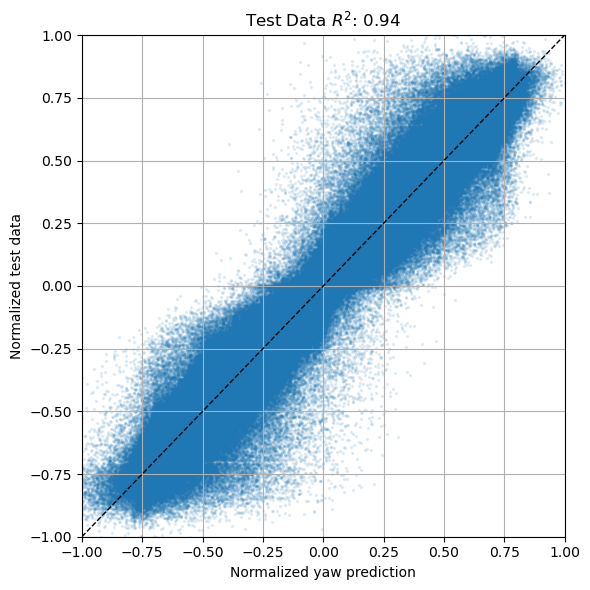

In [15]:
model.eval()
all_preds_test, all_true_test = [], []

with torch.no_grad():
    for xb, yb, maskb in test_loader:  # <-- use test_loader here
        xb, yb, maskb = xb.to(device), yb.to(device), maskb.to(device)
        y_pred = model(xb, maskb).squeeze()
        all_preds_test.append(y_pred.cpu())
        all_true_test.append(yb.cpu())

# Concatenate all batches
all_preds_test = torch.cat(all_preds_test).numpy()
all_true_test = torch.cat(all_true_test).numpy()

# Compute R^2 score
from sklearn.metrics import r2_score
r2_test = r2_score(all_true_test, all_preds_test)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(all_preds_test, all_true_test, s=2, alpha=0.1)
plt.xlabel("Normalized yaw prediction")
plt.ylabel("Normalized test data")
plt.title(f"Test Data $R^2$: {r2_test:.2f}")
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.plot([-1, 1], [-1, 1], 'k--', lw=1)
plt.tight_layout()

In [12]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, max_error

# Denormalize predictions and true values
y_pred_deg = utils.denormalize(all_preds_test)
y_true_deg = utils.denormalize(all_true_test)

# Compute metrics
rmse_test = root_mean_squared_error(y_true_deg, y_pred_deg)  # RMSE
mae_test = mean_absolute_error(y_true_deg, y_pred_deg)
r2_test_denorm = r2_score(y_true_deg, y_pred_deg)

# Log results
print(f"Test Metrics (De-normalized):")
print(f"RMSE: {rmse_test:.4f}°")
print(f"MAE: {mae_test:.4f}°")
print(f"R²: {r2_test_denorm:.4f}")

Test Metrics (De-normalized):
RMSE: 1.5069°
MAE: 0.7675°
R²: 0.9398
